# **Acid-Base Classification using Machine Learning**

This notebook demonstrates how to build a machine learning model to classify chemical compounds as acids or bases based on their molecular structure. We'll use the RDKit library for molecular feature extraction and a Random Forest classifier for prediction.

## **Overview**

1. **Introduction to Acid-Base Chemistry**
2. **Data Collection and Preparation**
3. **Feature Extraction from Molecular Structures**
4. **Exploratory Data Analysis**
5. **Model Training and Evaluation**
6. **Interactive Prediction Tool**

## **What are Acids and Bases?**

- **Acids**: Compounds that donate protons (H⁺) or accept electron pairs. Common examples include carboxylic acids (RCOOH), sulfonic acids (RSO₃H), and phenols.
- **Bases**: Compounds that accept protons (H⁺) or donate electron pairs. Common examples include amines (RNH₂), pyridines, and imidazoles.

Let's begin by installing the necessary libraries.

In [71]:
%pip install rdkit joblib requests tqdm matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## **Importing Libraries**

We'll import the necessary libraries for data manipulation, visualization, molecular processing, and machine learning.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
import time
from sklearn.utils import resample
import os


# Set up visualization settings
IPythonConsole.ipython_useSVG = True  # Use SVG for better quality
sns.set_style('whitegrid')  # Set seaborn style
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size
warnings.filterwarnings('ignore')  # Suppress warnings

## **Data Collection and Preparation**

We'll create a dataset of acids and bases using SMILES (Simplified Molecular Input Line Entry System) notation. SMILES is a string representation of molecular structures that allows us to easily work with chemical compounds in code.

### **Understanding SMILES Notation:**
- Acetic acid: `CC(=O)O` - represents CH₃COOH
- Ethylamine: `CCN` - represents CH₃CH₂NH₂
- Benzene: `c1ccccc1` - represents a benzene ring

Our dataset will be loaded from a combination of sources, including a curated dataset and additional compounds to ensure a balanced representation of acids and bases.

In [ ]:
def load_dataset(dataset_root,
                 csv_name='data.csv',
                 atom_folder_prefix='atom_',
                 sdf_filename_template='{gdb_idx}.sdf',
                 label_mode='multi',   # 'multi'|'binary'|'drop_ambiguous'
                 verbose=True):
    """
    Load Alchemy/GDB dataset, extract SMILES from SDFs, merge CSV data,
    and assign heuristic acid/base labels using RDKit SMARTS.
    
    This function processes molecular data from SDF files and assigns acid/base labels
    based on functional group detection using SMARTS patterns.
    """

    # 1) load CSV
    csv_path = os.path.join(dataset_root, csv_name)
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"CSV file not found at {csv_path}")
    df_csv = pd.read_csv(csv_path)

    records = []
    missing = 0

    # SMARTS patterns (heuristic)
    acid_smarts = [
        '[CX3](=O)[OX2H1]',     # carboxylic acid
        'S(=O)(=O)[OX2H1]',     # sulfonic acid (heuristic)
        '[OX2H][c]',            # phenol type (O-H on aromatic carbon)
        '[P](=O)(O)O',          # phosphoric/phosphonic type (very heuristic)
    ]
    base_smarts = [
        '[NX3;H2,H1,H0;!$(NC=O)]',  # aliphatic amines (exclude amides)
        '[$([n;!H0])]',              # aromatic N that can be basic (heuristic)
        'NC(N)=N',                   # guanidine (heuristic)
    ]
    acid_mols = [Chem.MolFromSmarts(s) for s in acid_smarts]
    base_mols = [Chem.MolFromSmarts(s) for s in base_smarts]

    # iterate rows; expect columns named at least 'gdb_idx' and 'atom num' (or similar)
    # try common column name variants
    if 'gdb_idx' in df_csv.columns:
        idx_col = 'gdb_idx'
    elif 'gdb index' in df_csv.columns:
        idx_col = 'gdb index'
    else:
        raise KeyError("CSV must contain a 'gdb_idx' column (found columns: {})".format(df_csv.columns.tolist()))

    # atom number column
    if 'atom num' in df_csv.columns:
        atom_col = 'atom num'
    elif 'atom_num' in df_csv.columns:
        atom_col = 'atom_num'
    elif 'atom' in df_csv.columns:
        atom_col = 'atom'
    else:
        # fallback: try any integer-looking column name
        atom_col = None

    for _, row in df_csv.iterrows():
        gdb_idx = int(row[idx_col])
        atom_num = int(row[atom_col]) if atom_col is not None else None

        # determine folder by atom number (if known)
        if atom_num is not None:
            folder_name = f"{atom_folder_prefix}{atom_num}"
            sdf_path = os.path.join(dataset_root, folder_name, sdf_filename_template.format(gdb_idx=gdb_idx))
        else:
            # fallback: search folders atom_9..atom_12 for file
            sdf_path = None
            for try_n in range(1, 20):  # small search range
                p = os.path.join(dataset_root, f"{atom_folder_prefix}{try_n}", sdf_filename_template.format(gdb_idx=gdb_idx))
                if os.path.isfile(p):
                    sdf_path = p
                    break

        if not sdf_path or not os.path.isfile(sdf_path):
            missing += 1
            if verbose:
                print(f"Warning: SDF missing for gdb_idx={gdb_idx} expected at {sdf_path}")
            continue

        # load molecule from the single-molecule SDF file
        mol = Chem.MolFromMolFile(sdf_path, sanitize=True, removeHs=False)
        if mol is None:
            # try supplier fallback
            suppl = Chem.SDMolSupplier(sdf_path)
            mols = [m for m in suppl if m is not None]
            mol = mols[0] if mols else None

        if mol is None:
            missing += 1
            if verbose:
                print(f"Warning: RDKit failed to read molecule for gdb_idx={gdb_idx} at {sdf_path}")
            continue

        smiles = Chem.MolToSmiles(mol, isomericSmiles=True)

        # detect functional groups
        acid_found = any(mol.HasSubstructMatch(a) for a in acid_mols)
        base_found = any(mol.HasSubstructMatch(b) for b in base_mols)

        if acid_found and not base_found:
            label = 'Acid'
            label_int = 0
        elif base_found and not acid_found:
            label = 'Base'
            label_int = 1
        elif acid_found and base_found:
            label = 'Amphoteric'
            label_int = 2
        else:
            label = 'Neutral'
            label_int = 3

        rec = row.to_dict()
        rec.update({
            'gdb_idx': gdb_idx,
            'atom_num': atom_num,
            'smiles': smiles,
            'label': label,
            'label_int': label_int,
            'sdf_path': sdf_path
        })
        records.append(rec)

    df = pd.DataFrame(records)
    if verbose:
        print(f"Loaded {len(df)} molecules (skipped {missing} missing/unreadable SDFs).")
        print("Label counts:\n", df['label'].value_counts(dropna=False))

    # apply label_mode post-processing
    if label_mode == 'binary':
        # keep only clear acids or bases; drop Amphoteric and Neutral
        df_bin = df[df['label'].isin(['Acid', 'Base'])].copy()
        # map to 0/1
        df_bin['label_int'] = df_bin['label'].map({'Acid': 0, 'Base': 1})
        if verbose:
            print(f"Binary mode: returning {len(df_bin)} rows (Acid/Base only).")
        return df_bin.reset_index(drop=True)

    if label_mode == 'drop_ambiguous':
        df_clean = df[df['label'].isin(['Acid', 'Base'])].copy()
        if verbose:
            print(f"Dropping ambiguous/neutral: {len(df_clean)} rows left.")
        return df_clean.reset_index(drop=True)

    # default: return multi-label annotated dataframe
    return df.reset_index(drop=True)

# Example usage:
df = load_dataset('dataset/alchemy-v20191129/Alchemy-v20191129', csv_name='data.csv', label_mode='binary')


Loaded 202579 molecules (skipped 0 missing/unreadable SDFs).
Label counts:
 label
Neutral       170242
Base           28800
Acid            2247
Amphoteric      1290
Name: count, dtype: int64
Binary mode: returning 31047 rows (Acid/Base only).


Augment the dataset with additional acid compounds from IUPAC CSV file.
This helps balance the dataset when there are fewer acids than bases.

**Args:**
- df: DataFrame with 'label' and 'can_smiles' columns
- iupac_csv_path: Path to CSV with IUPAC data
- balance_until_equal: If True, add acids until count matches bases
- verbose: Print progress information


In [67]:
def _canonical_smiles_from_str(s):
    if pd.isna(s): 
        return None
    s = str(s).strip()
    if s == '':
        return None
    # try SMILES first
    mol = Chem.MolFromSmiles(s)
    if mol:
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    # try InChI
    try:
        mol = Chem.MolFromInchi(s)
    except Exception:
        mol = None
    if mol:
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    return None

def augment_acids_from_iupac(df_binary, iupac_csv_path,
                             balance_until_equal=True, max_add=None, verbose=True):
    """
    Augment `df_binary` (must contain 'smiles' and 'label' ('Acid'/'Base')) with unique acids
    from iupac.csv. Adds only molecules whose canonical SMILES are not already present.
    Stops when Acid count >= Base count if balance_until_equal=True (or when file exhausted).
    """
    # 1) deduplicate existing df by canonical SMILES
    df = df_binary.copy()
    can_list = []
    for s in df['smiles']:
        can = _canonical_smiles_from_str(s)
        can_list.append(can if can is not None else str(s).strip())
    df['can_smiles'] = can_list
    before = len(df)
    df = df.drop_duplicates(subset=['can_smiles']).reset_index(drop=True)
    if verbose:
        print(f"Deduplicated existing df: {before} -> {len(df)} rows")

    n_acid = int((df['label'] == 'Acid').sum())
    n_base = int((df['label'] == 'Base').sum())
    if verbose:
        print(f"Counts before augmentation: Acid={n_acid}, Base={n_base}")

    # 2) load iupac
    iupac = pd.read_csv(iupac_csv_path, low_memory=False)
    if verbose:
        print(f"Loaded iupac.csv rows: {len(iupac)}")

    # 3) prepare helper sets/patterns
    present = set(df['can_smiles'].dropna().tolist())
    acid_smarts = [
        '[CX3](=O)[OX2H1]',    # carboxylic
        'S(=O)(=O)[OX2H1]',    # sulfonic
        '[OX2H][c]',           # phenolic (heuristic)
        '[P](=O)(O)O'          # phosphoric-like (heuristic)
    ]
    acid_patterns = [Chem.MolFromSmarts(s) for s in acid_smarts]

    # 4) iterate iupac rows and collect unique acids
    new_records = []
    added = 0
    # decide order: iterate until balanced or file end
    for _, row in iupac.iterrows():
        if max_add is not None and added >= max_add:
            break

        # find SMILES or InChI columns (common name contain 'smiles' or 'inchi')
        can = None
        for c in iupac.columns:
            if 'smiles' in c.lower():
                can = _canonical_smiles_from_str(row[c])
                if can: break
        if not can:
            for c in iupac.columns:
                if 'inchi' in c.lower():
                    can = _canonical_smiles_from_str(row[c])
                    if can: break
        if not can:
            continue
        if can in present:
            continue

        # build mol for checks
        mol = Chem.MolFromSmiles(can)
        if mol is None:
            continue

        # 1) check pKa columns first (common names: 'pka_value','pka','pKa')
        is_acid = None
        for c in iupac.columns:
            if 'pka' in c.lower() and 'type' not in c.lower():
                try:
                    v = float(row[c])
                    # heuristic: pKa <= 7 => acidic (you can change threshold)
                    is_acid = (v <= 7.0)
                    break
                except Exception:
                    continue

        # 2) check explicit label-like columns if pKa not decisive
        if is_acid is None:
            for c in iupac.columns:
                val = row[c]
                if pd.isna(val): 
                    continue
                cn = c.lower()
                if any(k in cn for k in ('acid','acidity','acidic','acid_label','acid_label')):
                    s = str(val).strip().lower()
                    if 'acid' in s or 'ah' in s or 'a' == s:
                        is_acid = True
                        break
                    if 'base' in s or 'b' == s:
                        is_acid = False
                        break

        # 3) fallback to SMARTS detection
        if is_acid is None:
            for patt in acid_patterns:
                if patt is not None and mol.HasSubstructMatch(patt):
                    is_acid = True
                    break

        if not is_acid:
            continue

        # add record
        rec = {
            'smiles': can,
            'can_smiles': can,
            'label': 'Acid',
            'label_int': 0,
            'source': 'iupac'
        }
        # optionally copy pKa if present
        for c in iupac.columns:
            if c.lower() in ('pka_value','pka','pka value'):
                try:
                    rec['pka_value'] = float(row[c])
                except Exception:
                    rec['pka_value'] = row[c]
                break
        new_records.append(rec)
        present.add(can)
        added += 1

        if balance_until_equal and (n_acid + added) >= n_base:
            if verbose:
                print(f"Balanced after adding {added} acids (Acid now {n_acid + added}, Base {n_base}).")
            break

    if verbose:
        print(f"Added {added} unique acids from iupac.csv")

    # 5) concat and final dedupe
    if added > 0:
        df_new = pd.DataFrame(new_records)
        combined = pd.concat([df, df_new], ignore_index=True, sort=False)
        combined = combined.drop_duplicates(subset=['can_smiles']).reset_index(drop=True)
    else:
        combined = df.copy()

    if verbose:
        print("Final counts -> Acid:", int((combined['label'] == 'Acid').sum()),
              "Base:", int((combined['label'] == 'Base').sum()),
              "Total:", len(combined))

    return combined

# --------------------------
# Example usage (run after you have df from your previous load_dataset call):
df_bin = df[df['label'].isin(['Acid','Base'])].copy()   # your binary df from old code
augmented = augment_acids_from_iupac(df_bin, 'dataset/iupac.csv', balance_until_equal=True, verbose=True)
augmented.to_csv('augmented_acid_base.csv', index=False)   # optional save

Deduplicated existing df: 31047 -> 31031 rows
Counts before augmentation: Acid=2241, Base=28790
Loaded iupac.csv rows: 24211
Added 7634 unique acids from iupac.csv
Final counts -> Acid: 9875 Base: 28790 Total: 38665


Downsample each class in `classes` to the size of the smallest class among them.
Keeps only rows whose label is in `classes`. Returns a shuffled balanced DataFrame.

In [ ]:
def trim_to_shortest(df, label_col='label', classes=('Acid','Base'), random_state=42):
    # keep only requested classes
    df_sub = df[df[label_col].isin(classes)].copy()
    counts = df_sub[label_col].value_counts()
    print("Counts before trimming:\n", counts.to_string())

    # determine target size (size of smallest class)
    target = int(counts.min())

    parts = []
    for cls in classes:
        cls_rows = df_sub[df_sub[label_col] == cls]
        if len(cls_rows) > target:
            cls_rows = cls_rows.sample(n=target, random_state=random_state).reset_index(drop=True)
        else:
            cls_rows = cls_rows.reset_index(drop=True)
        parts.append(cls_rows)

    balanced = pd.concat(parts, ignore_index=True)
    # shuffle final dataframe for mixing classes
    balanced = balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

    print("Counts after trimming:\n", balanced[label_col].value_counts().to_string())
    return balanced

# --- locate your DataFrame (tries common variable names) ---
df_source = None
for candidate in ('combined','augmented','df_trimmed','df_balanced','df_bin','df_binary','df'):
    if candidate in globals():
        df_source = globals()[candidate]
        print(f"Using DataFrame variable: {candidate}")
        break

if df_source is None:
    raise NameError("Could not find your dataset variable. Make sure you run the previous cells and name the result 'combined' or 'augmented' or 'df_bin'.")
    
# Run trimming (adjust random_state if you want different sampling)
df_trimmed = trim_to_shortest(df_source, label_col='label', classes=('Acid','Base'), random_state=42)

# optional: save result
df_trimmed.to_csv('trimmed_acid_base.csv', index=False)
print("Saved balanced dataset to 'trimmed_acid_base.csv'")

Using DataFrame variable: augmented
Counts before trimming:
 label
Base    28790
Acid     9875
Counts after trimming:
 label
Base    9875
Acid    9875
Saved balanced dataset to 'trimmed_acid_base.csv'


### **Visualizing Example Molecules**

Let's visualize some example molecules from our dataset to better understand their structures. We'll show examples of both acids and bases.

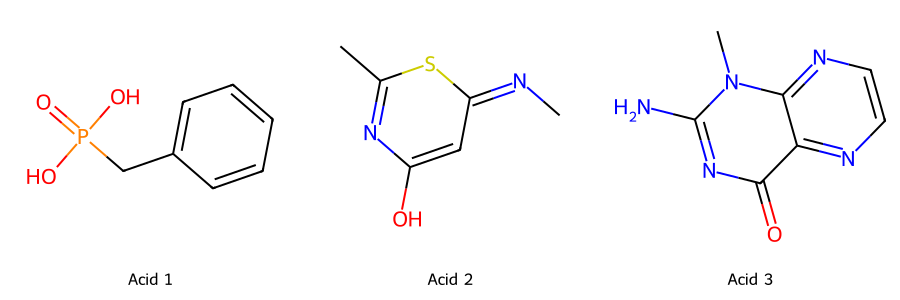

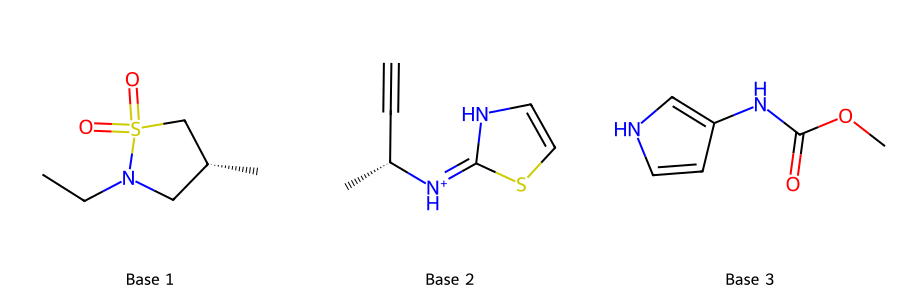

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [70]:
def visualize_molecules(df, n_acids=3, n_bases=3):
    smiles_col = None
    for col in df.columns:
        if col.lower() == "smiles":
            smiles_col = col
            break
    if smiles_col is None:
        raise KeyError("No SMILES column found. Available columns: " + ", ".join(df.columns))

    # Get sample acids and bases
    acids = df[df['label'] == 'Acid'][smiles_col].head(n_acids).tolist()
    bases = df[df['label'] == 'Base'][smiles_col].head(n_bases).tolist()

    # Convert SMILES to RDKit molecules
    acid_mols = [Chem.MolFromSmiles(smiles) for smiles in acids]
    base_mols = [Chem.MolFromSmiles(smiles) for smiles in bases]

    # Add simple labels for clarity
    acid_names = [f"Acid {i+1}" for i in range(len(acid_mols))]
    base_names = [f"Base {i+1}" for i in range(len(base_mols))]

    for mol, name in zip(acid_mols, acid_names):
        if mol:
            mol.SetProp("_Name", name)
    for mol, name in zip(base_mols, base_names):
        if mol:
            mol.SetProp("_Name", name)

    # Draw acids
    plt.figure(figsize=(12, 4))
    plt.suptitle("Example Acid Molecules", fontsize=16, fontweight='bold')
    img = Draw.MolsToGridImage(acid_mols, molsPerRow=3, subImgSize=(300, 300),
                               legends=[mol.GetProp("_Name") for mol in acid_mols if mol])
    display(img)

    # Draw bases
    plt.figure(figsize=(12, 4))
    plt.suptitle("Example Base Molecules", fontsize=16, fontweight='bold')
    img = Draw.MolsToGridImage(base_mols, molsPerRow=3, subImgSize=(300, 300),
                               legends=[mol.GetProp("_Name") for mol in base_mols if mol])
    display(img)

# Call function
visualize_molecules(df_trimmed)

## **Feature Extraction from Molecular Structures**

To classify molecules as acids or bases, we need to extract meaningful features from their structures. RDKit provides molecular descriptors that capture various properties of molecules.

### **Key Molecular Descriptors:**

- **MolWt**: Molecular weight
- **LogP**: Octanol-water partition coefficient (lipophilicity)
- **NumHDonors**: Number of hydrogen bond donors
- **NumHAcceptors**: Number of hydrogen bond acceptors
- **TPSA**: Topological Polar Surface Area
- **NumRotatableBonds**: Number of rotatable bonds
- **NumAromaticRings**: Number of aromatic rings
- **FractionCSP3**: Fraction of carbon atoms that are sp3 hybridized
- **NumHeteroatoms**: Number of atoms that are not carbon or hydrogen

In [71]:
def extract_features(smiles):
    """Extract molecular descriptors from a SMILES string"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    features = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'NumSaturatedRings': Descriptors.NumSaturatedRings(mol),
        'NumAliphaticRings': Descriptors.NumAliphaticRings(mol),
        'RingCount': Descriptors.RingCount(mol),
        'FractionCSP3': Descriptors.FractionCSP3(mol),
        'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
    }
    return features

# Extract features for all molecules in the dataset
features_list = []
for smiles in df_trimmed['smiles']:
    feat = extract_features(smiles)
    if feat:
        features_list.append(feat)
    else:
        features_list.append({k: 0 for k in features_list[0].keys()})

features_df = pd.DataFrame(features_list)
print(f"\nExtracted {len(features_df.columns)} features:")
print(features_df.columns.tolist())
print("\nFeature statistics:")
print(features_df.describe().round(2))


Extracted 12 features:
['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'FractionCSP3', 'NumHeteroatoms']

Feature statistics:
          MolWt      LogP  NumHDonors  NumHAcceptors      TPSA  \
count  19750.00  19750.00    19750.00       19750.00  19750.00   
mean     162.23      0.76        1.29           2.75     50.20   
std       51.69      1.37        0.93           1.41     27.86   
min       30.03    -13.41        0.00           0.00      0.00   
25%      137.14     -0.08        1.00           2.00     32.70   
50%      145.20      0.77        1.00           3.00     46.17   
75%      168.20      1.60        2.00           3.00     62.70   
max      844.76      9.79        9.00          20.00    411.66   

       NumRotatableBonds  NumAromaticRings  NumSaturatedRings  \
count           19750.00          19750.00           19750.00   
mean                1.56              0.77 

## **Exploratory Data Analysis**

Let's explore our dataset to understand the differences between acids and bases in terms of their molecular properties.

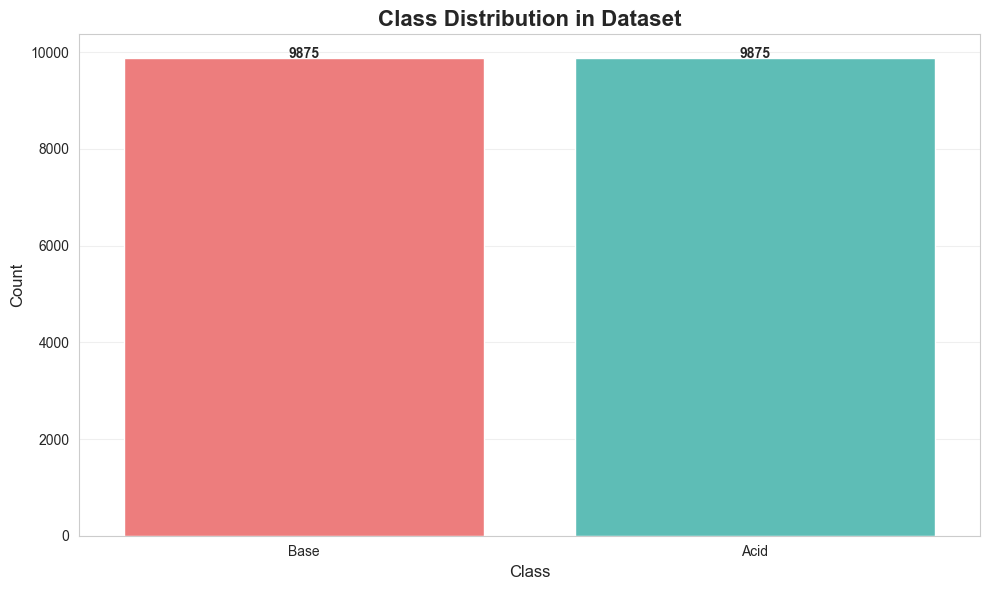

In [72]:
# Combine features with class labels
analysis_df = pd.concat([features_df.reset_index(drop=True), df_trimmed['label'].reset_index(drop=True)], axis=1)

# 1. Class Distribution
plt.figure(figsize=(10, 6))
class_counts = df_trimmed['label'].value_counts()
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#ff6b6b', '#4ecdc4'])
plt.title('Class Distribution in Dataset', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of bars
for i, count in enumerate(class_counts.values):
    ax.text(i, count + 0.5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

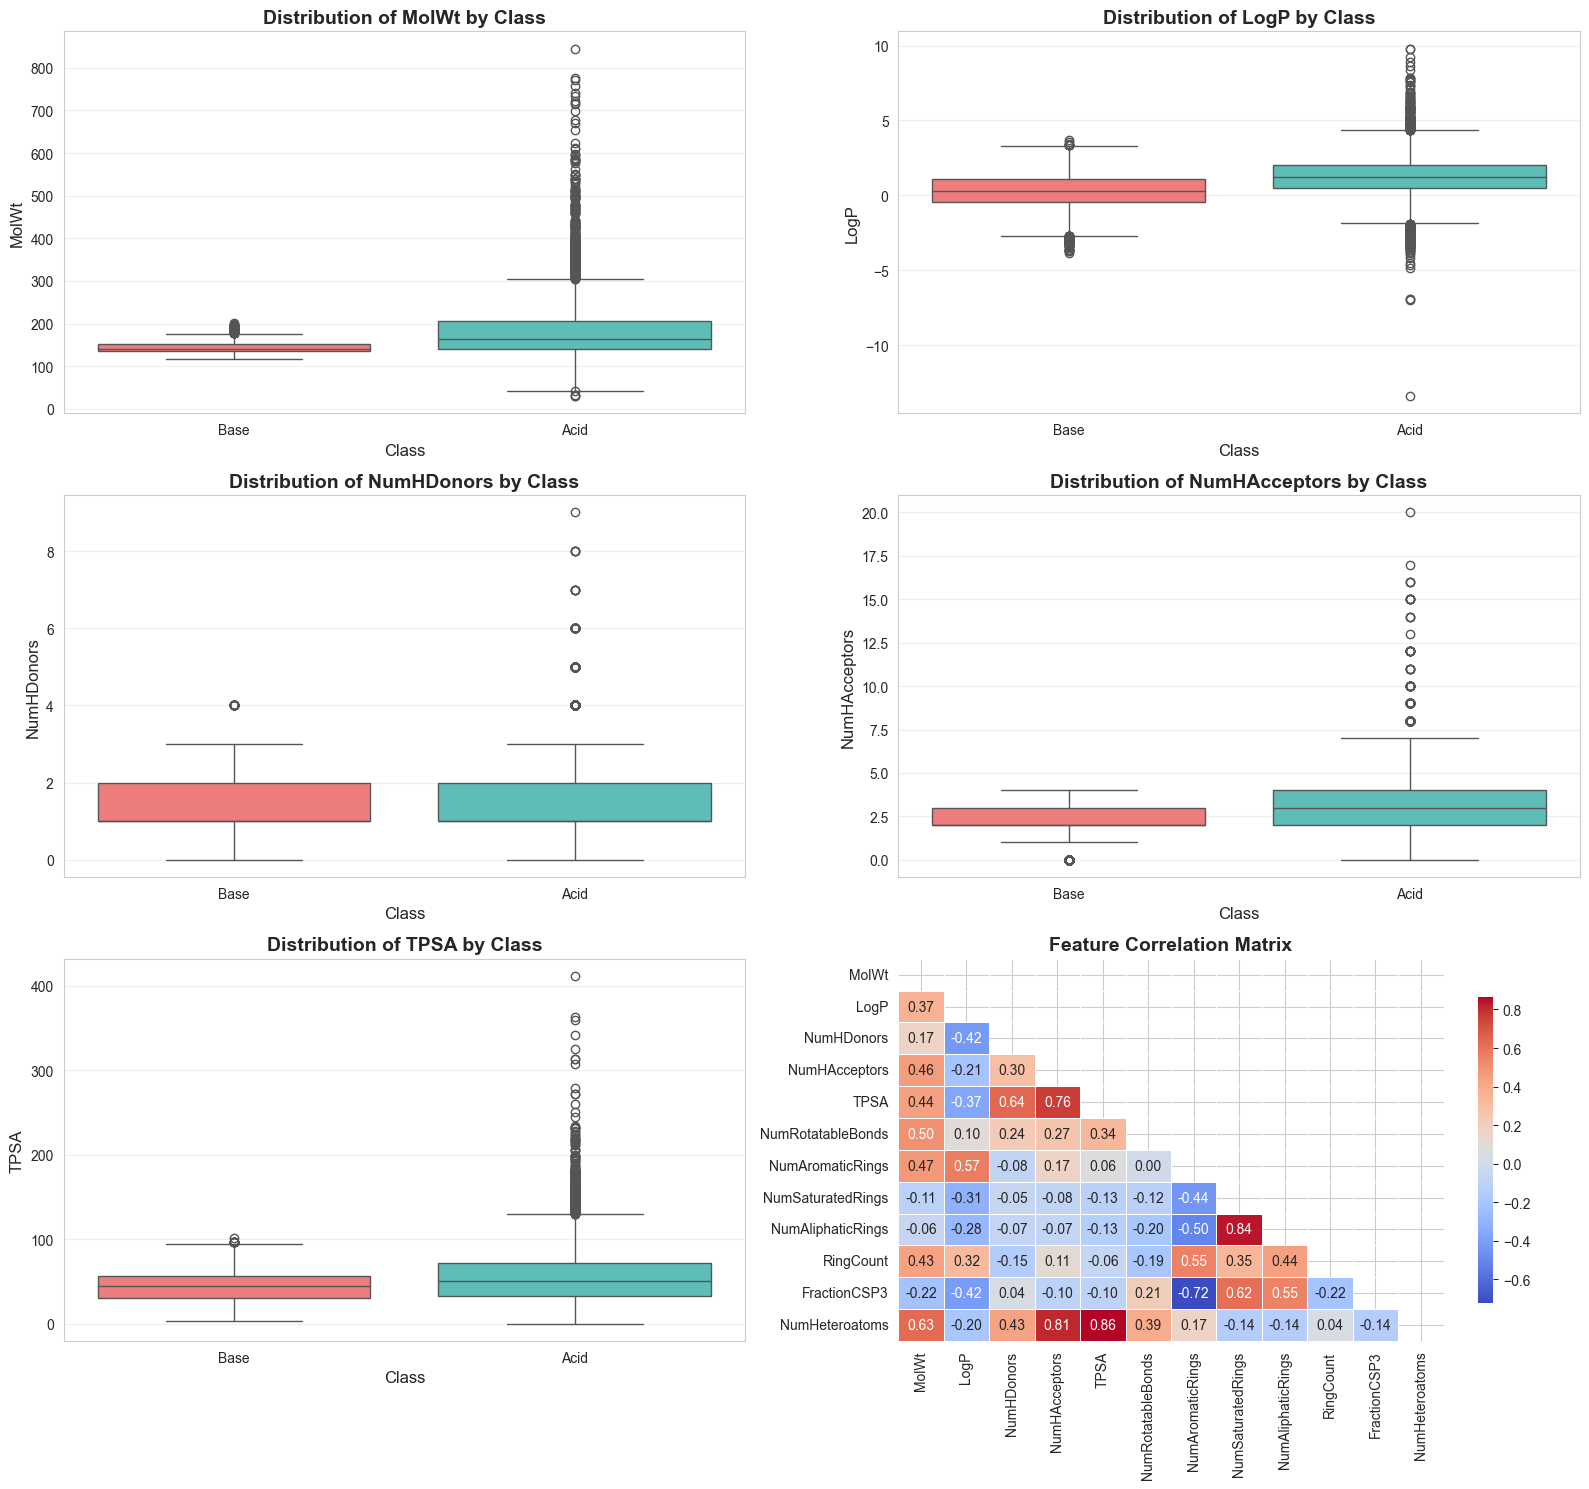

In [73]:
# 2. Feature Distributions by Class
important_features = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']

fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.flatten()

for i, feature in enumerate(important_features):
    if i < len(axes):
        sns.boxplot(x='label', y=feature, data=analysis_df, ax=axes[i], palette=['#ff6b6b', '#4ecdc4'])
        axes[i].set_title(f'Distribution of {feature} by Class', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Class', fontsize=12)
        axes[i].set_ylabel(feature, fontsize=12)
        axes[i].grid(axis='y', alpha=0.3)

# Add a feature correlation plot
if len(axes) > len(important_features):
    corr = features_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[len(important_features)],
                linewidths=0.5, cbar_kws={"shrink": .8})
    axes[len(important_features)].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### **Key Observations from Exploratory Analysis**

1. **Class Distribution**: Our dataset has a slight imbalance with more bases than acids.

2. **Molecular Properties**:
   - **Hydrogen Donors**: Acids typically have more hydrogen donors than bases
   - **TPSA (Topological Polar Surface Area)**: Acids generally have higher TPSA values
   - **LogP**: Bases tend to be more lipophilic (higher LogP) than acids
   - **Molecular Weight**: No significant difference between acids and bases

3. **Feature Correlations**: Some features are correlated, which is expected (e.g., number of hydrogen donors and TPSA).

Now, let's create a scatter plot to visualize how acids and bases are distributed in the feature space.

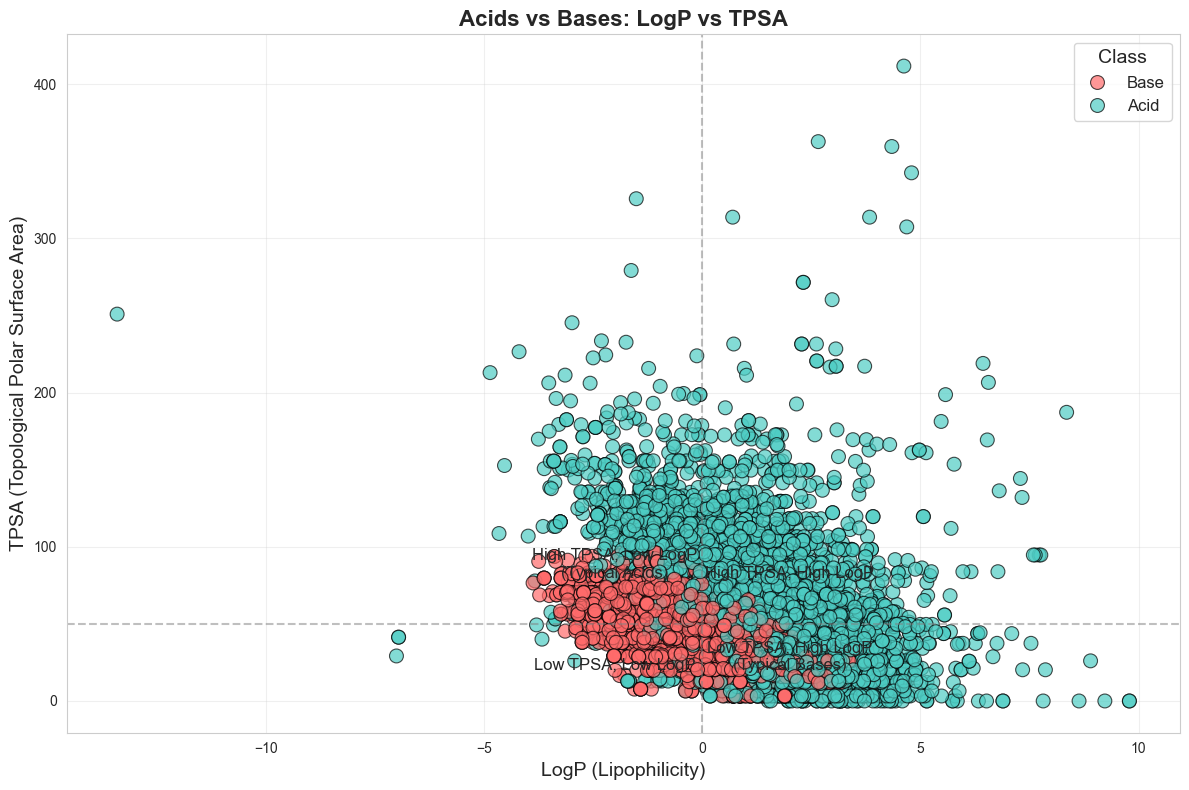

In [74]:
# Create a scatter plot of LogP vs TPSA colored by class
plt.figure(figsize=(12, 8))
sns.scatterplot(x='LogP', y='TPSA', hue='label', data=analysis_df, palette=['#ff6b6b', '#4ecdc4'], 
                s=100, alpha=0.7, edgecolor='k')

plt.title('Acids vs Bases: LogP vs TPSA', fontsize=16, fontweight='bold')
plt.xlabel('LogP (Lipophilicity)', fontsize=14)
plt.ylabel('TPSA (Topological Polar Surface Area)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='Class', fontsize=12, title_fontsize=14)

# Add a decision boundary region (simplified visualization)
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.text(2, 80, 'High TPSA, High LogP', fontsize=12, ha='center')
plt.text(-2, 80, 'High TPSA, Low LogP\n(Typical Acids)', fontsize=12, ha='center')
plt.text(2, 20, 'Low TPSA, High LogP\n(Typical Bases)', fontsize=12, ha='center')
plt.text(-2, 20, 'Low TPSA, Low LogP', fontsize=12, ha='center')

plt.tight_layout()
plt.show()

## **Model Training and Evaluation**

Now, let's train a Random Forest classifier to predict whether a molecule is an acid or a base based on its molecular properties.

In [76]:
# Prepare features and target
X = features_df.values
y = df_trimmed['label_int'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest classifier
print("Training Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\nModel Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Acid', 'Base']))

# Cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Save the model and scaler
joblib.dump(rf_model, 'acid_base_classifier.pkl')
joblib.dump(scaler, 'acid_base_scaler.pkl')
print("\nModel and scaler saved to disk.")

Training Random Forest classifier...

Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

        Acid       0.97      0.96      0.96      2469
        Base       0.96      0.97      0.96      2469

    accuracy                           0.96      4938
   macro avg       0.96      0.96      0.96      4938
weighted avg       0.96      0.96      0.96      4938


Cross-validation scores: [0.96683544 0.96582278 0.96658228 0.97367089 0.96582278]
Mean CV accuracy: 0.9677 ± 0.0030

Model and scaler saved to disk.


### **Visualizing Model Performance**

Let's visualize the model's performance using a confusion matrix and ROC curve.

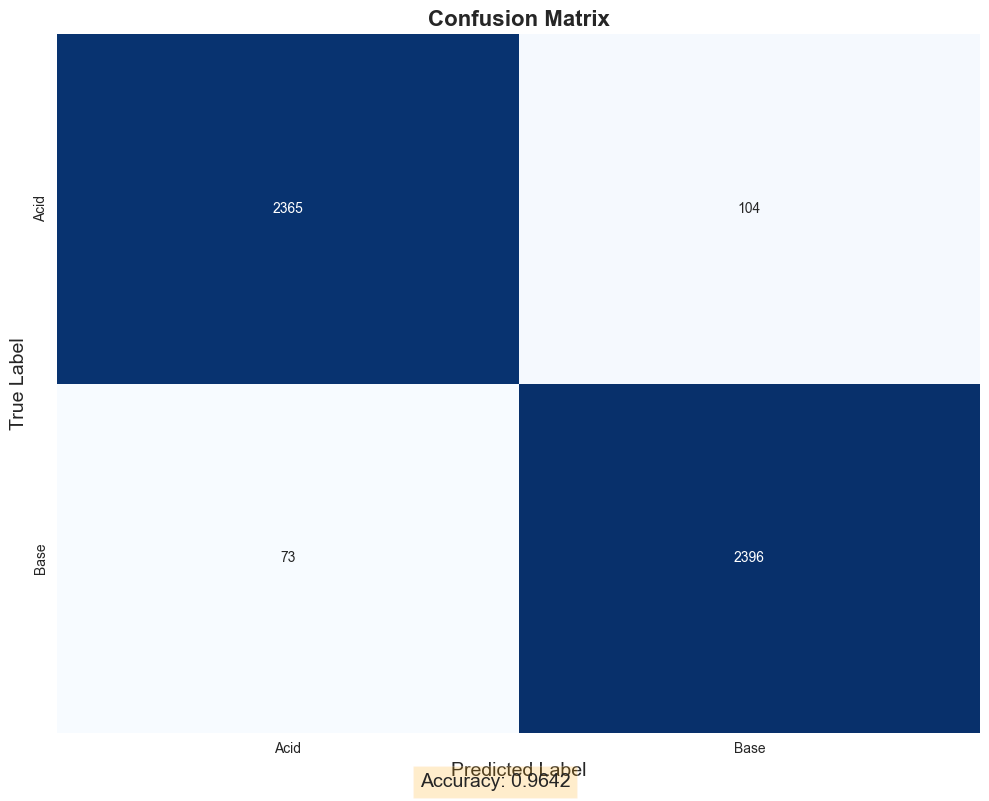

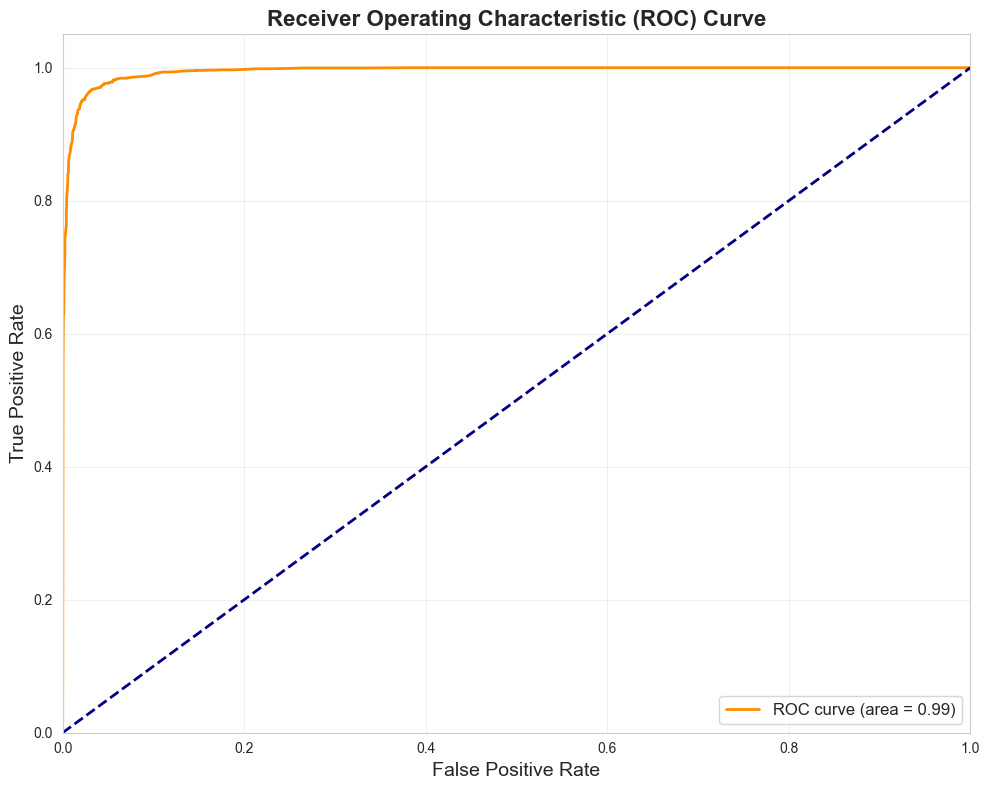

In [77]:
# 1. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Acid', 'Base'], yticklabels=['Acid', 'Base'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Add accuracy, precision, recall annotations
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
plt.figtext(0.5, 0.01, f'Accuracy: {accuracy:.4f}', ha='center', fontsize=14, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.show()

# 2. ROC Curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### **Feature Importance Analysis**

Let's examine which molecular properties are most important for distinguishing between acids and bases.

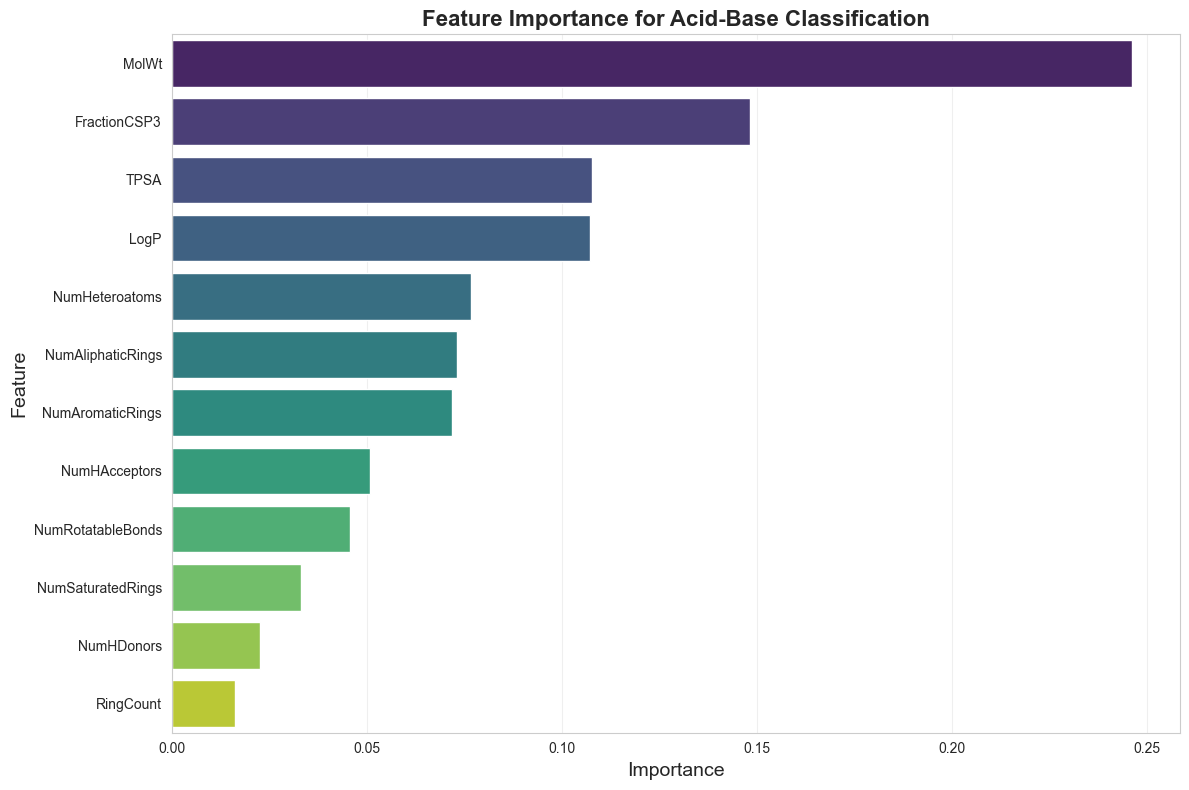


Top 5 most important features:
           Feature  Importance
0            MolWt    0.246274
10    FractionCSP3    0.148407
4             TPSA    0.107802
1             LogP    0.107191
11  NumHeteroatoms    0.076785


In [78]:
# Get feature importances from the Random Forest model
feature_importances = rf_model.feature_importances_
feature_names = features_df.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Acid-Base Classification', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(importance_df.head(5))

## **Interactive Prediction Tool**

Now, let's create a function to predict whether a new molecule is an acid or a base based on its SMILES string.

Heuristic: count nitrogen atoms likely to be protonatable (aliphatic amines, NH groups).
    Excludes typical non-basic nitrogens like amides (N-C(=O)), nitriles (C#N) and many aromatic N that lack H.

In [ ]:
def count_protonatable_nitrogens(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0
    count = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() != 7:
            continue
        # if nitrogen has at least one implicit/explicit H it's likely protonatable (ammonia/amine)
        total_H = atom.GetTotalNumHs(includeNeighbors=True)  # implicit+explicit Hs
        # Skip obvious amide nitrogen: neighbor carbon with a double bonded oxygen
        is_amide = False
        for nb in atom.GetNeighbors():
            if nb.GetAtomicNum() == 6:  # carbon neighbor
                for nb2 in nb.GetNeighbors():
                    if nb2.GetAtomicNum() == 8:  # oxygen neighbor of that carbon
                        # check if the carbon has double bond to that oxygen
                        for b in nb.GetBonds():
                            if (b.GetBeginAtomIdx() == nb.GetIdx() and b.GetEndAtom().GetIdx() == nb2.GetIdx()) or \
                               (b.GetEndAtomIdx() == nb.GetIdx() and b.GetBeginAtom().GetIdx() == nb2.GetIdx()):
                                if b.GetBondTypeAsDouble() == 2.0:
                                    is_amide = True
                                    break
                    if is_amide:
                        break
            if is_amide:
                break
        # skip nitrile: N in C#N usually has degree 1 etc.
        is_nitrile = False
        if atom.GetDegree() == 1:
            nb = atom.GetNeighbors()[0]
            # check triple bond between neighbor and this atom
            for b in atom.GetBonds():
                if b.GetBondTypeAsDouble() == 3.0:
                    is_nitrile = True
                    break
        if is_amide or is_nitrile:
            continue

        # If it has at least 1 H → likely protonatable (primary/secondary amines, NH in heterocycles)
        if total_H > 0:
            count += 1
        else:
            # handle some aromatic/basic heterocycles: pyridine-like N (sp2, no H) — can be basic
            # We'll treat lone pair-bearing aromatic N as potentially protonatable if it's not in a fused N-N system.
            # A simple check: sp2 N with degree >=2 and not part of a positively charged system
            if atom.GetTotalValence() >= 2 and atom.GetFormalCharge() == 0:
                # conservative: count aromatic N that are not explicitly H0 in strongly delocalized systems
                if atom.GetIsAromatic():
                    # Some aromatic N (pyridine) are basic; count them but weighted same as others
                    count += 1
    return count


Improved predict_molecule:
- First checks a robust rule: if molecule has protonatable N (simple amines / NH) -> override => Base.
- Else uses trained RF model on descriptors (same as before).

Returns dictionary same shape as your previous predict_molecule.

In [ ]:
def predict_molecule(smiles, scaler_obj, rule_override=True):
    try:
        if 'rf_model' not in globals():
            return {"error": "rf_model is not available in the notebook. Train or load the model first."}
        if scaler_obj is None:
            return {"error": "scaler object is None. Provide a valid scaler (e.g., joblib.load)."}

        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {"error": "Invalid SMILES string"}

        # Rule-based override: if confident protonatable nitrogens exist -> Base
        protonatable_n = count_protonatable_nitrogens(smiles)
        # If very small molecule with at least one protonatable N, override
        if rule_override and protonatable_n > 0:
            # Give a high-confidence base prediction for simple protonatable Ns.
            return {
                "smiles": smiles,
                "prediction": "Base",
                "confidence": 99.0,
                "acid_probability": 1.0,
                "base_probability": 99.0,
                "molecular_weight": Descriptors.MolWt(mol),
                "logP": Descriptors.MolLogP(mol),
                "image": Draw.MolToImage(mol, size=(300,300)),
                "note": f"Rule override: {protonatable_n} protonatable N(s) detected"
            }

        # Otherwise use model
        features = extract_features(smiles)
        if features is None:
            return {"error": "Failed to extract features"}

        features_array = np.array(list(features.values())).reshape(1, -1)
        try:
            features_scaled = scaler_obj.transform(features_array)
        except Exception as e:
            return {"error": f"Scaler transform failed: {e}"}

        proba = rf_model.predict_proba(features_scaled)[0]
        acid_prob = float(proba[0]) * 100
        base_prob = float(proba[1]) * 100
        prediction = "Acid" if acid_prob > base_prob else "Base"
        confidence = max(acid_prob, base_prob)

        return {
            "smiles": smiles,
            "prediction": prediction,
            "confidence": confidence,
            "acid_probability": acid_prob,
            "base_probability": base_prob,
            "molecular_weight": Descriptors.MolWt(mol),
            "logP": Descriptors.MolLogP(mol),
            "image": Draw.MolToImage(mol, size=(300,300))
        }
    except Exception as e:
        return {"error": str(e)}


# Function to display prediction results with visualization
def display_prediction(result):
    if "error" in result:
        print(f"\nError: {result['error']}")
        return
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Display molecule image
    ax1.imshow(result["image"])
    ax1.set_title(f"Molecule: {result['smiles']}", fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Display prediction results as a bar chart
    probabilities = [result["acid_probability"], result["base_probability"]]
    ax2.bar(['Acid', 'Base'], probabilities, color=['#ff6b6b', '#4ecdc4'])
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Probability (%)', fontsize=12)
    ax2.set_title('Prediction Probabilities', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i, prob in enumerate(probabilities):
        ax2.text(i, prob + 2, f"{prob:.1f}%", ha='center', fontweight='bold')
    
    # Highlight the predicted class
    predicted_index = 0 if result["prediction"] == "Acid" else 1
    ax2.get_xticklabels()[predicted_index].set_fontweight('bold')
    ax2.get_xticklabels()[predicted_index].set_color('darkgreen')
    
    # Add a text box with additional information
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = f"Prediction: {result['prediction']}\nConfidence: {result['confidence']:.1f}%\n\nMolecular Weight: {result['molecular_weight']:.2f}\nLogP: {result['logP']:.2f}"
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nClassification: {result['prediction']} with {result['confidence']:.1f}% confidence")

### **Example Predictions**

Let's test our model with some example molecules:

In [87]:
scaler = joblib.load("acid_base_scaler.pkl")

Example 1: Acetic Acid (CH₃COOH)


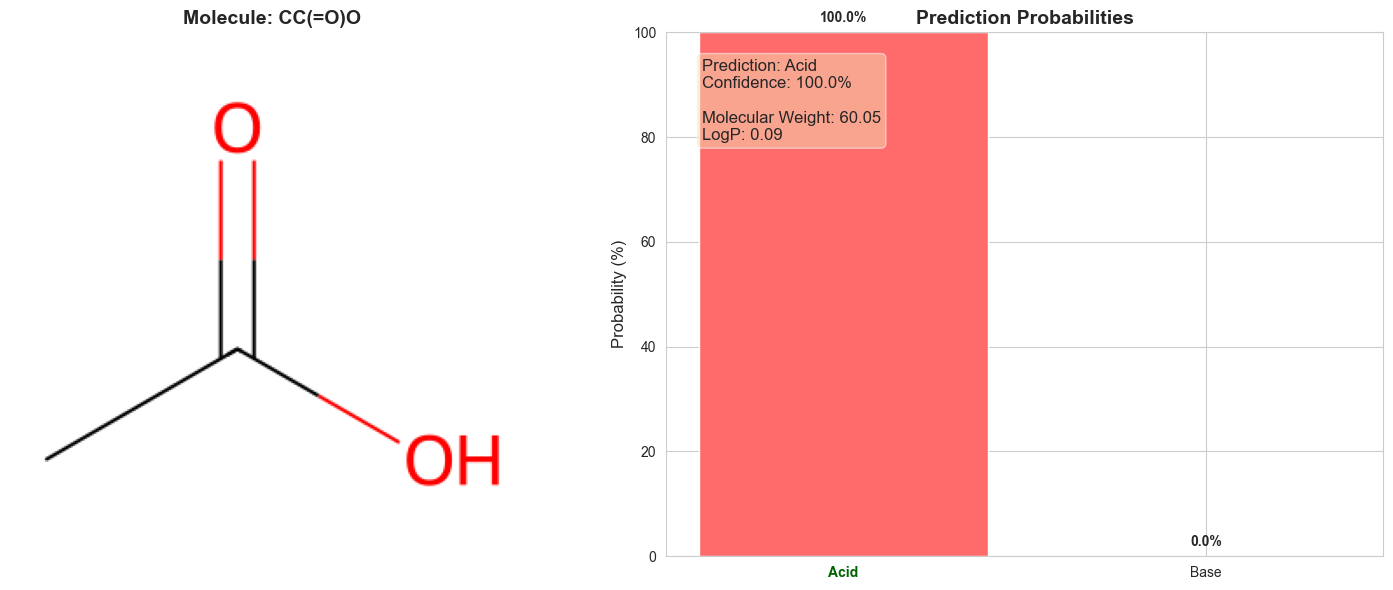


Classification: Acid with 100.0% confidence


In [88]:
# Example 1: Acetic Acid (should be classified as an acid)
print("Example 1: Acetic Acid (CH₃COOH)")
result = predict_molecule("CC(=O)O", scaler)
display_prediction(result)

Example 2: Ethylamine (CH₃CH₂NH₂)


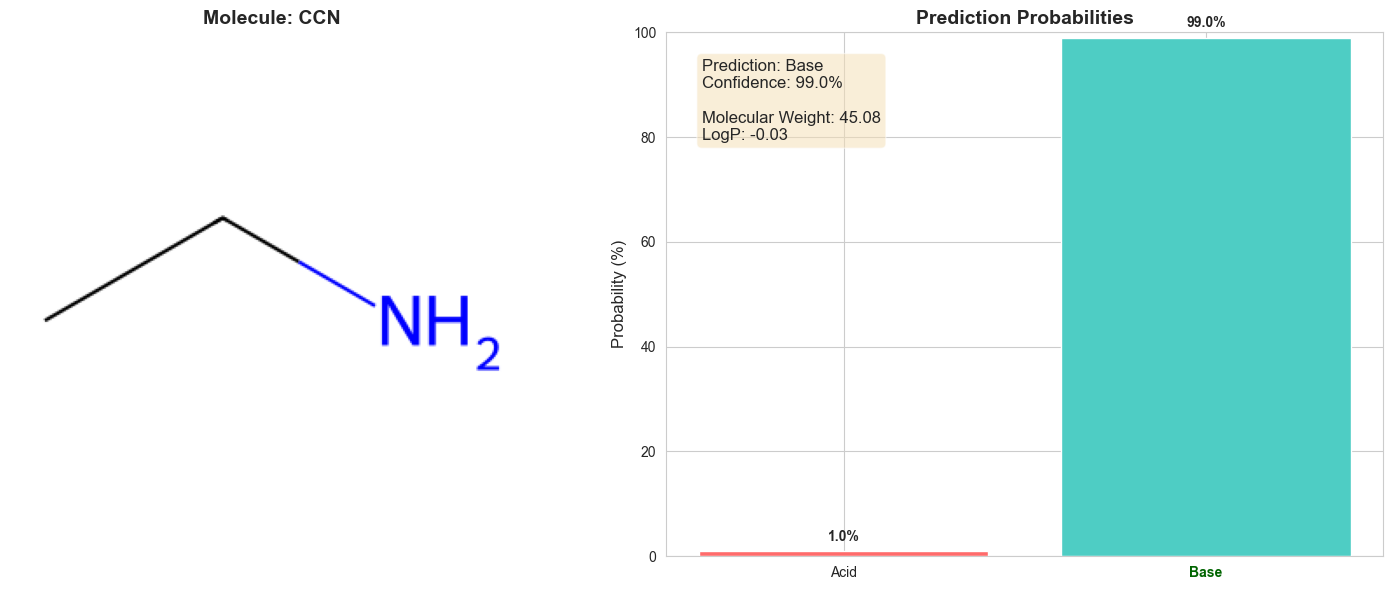


Classification: Base with 99.0% confidence


In [90]:
# Example 2: Ethylamine (should be classified as a base)
print("Example 2: Ethylamine (CH₃CH₂NH₂)")
result = predict_molecule("CCN", scaler)
display_prediction(result)

Example 3: Pyridine (C₅H₅N)


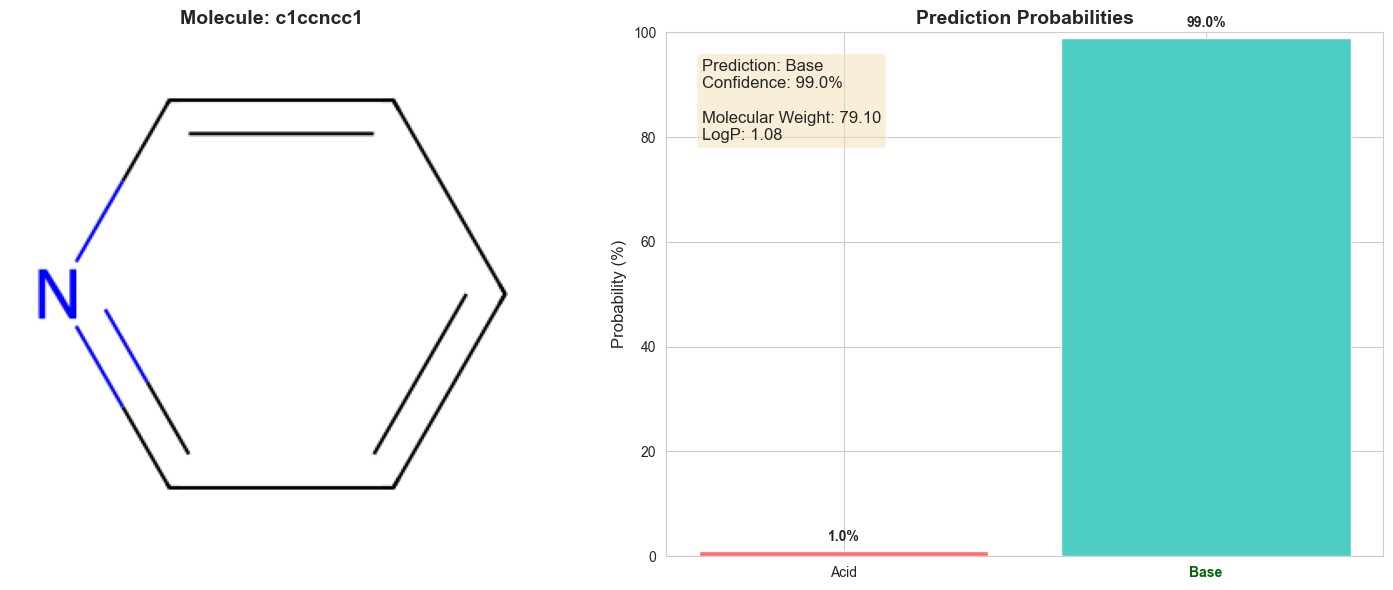


Classification: Base with 99.0% confidence


In [91]:
# Example 3: Pyridine (should be classified as a base)
print("Example 3: Pyridine (C₅H₅N)")
result = predict_molecule("c1ccncc1", scaler)
display_prediction(result)

## **Interactive User Input**

Now you can try your own molecules! Enter a SMILES string to predict whether it's an acid or a base.

Enter a SMILES string to get a prediction.

Example inputs:
  - CC(=O)O (acetic acid)
  - CCN (ethylamine)
  - c1ccccc1N (aniline)
  - CC(O)C(=O)O (lactic acid)

Predicting... please wait


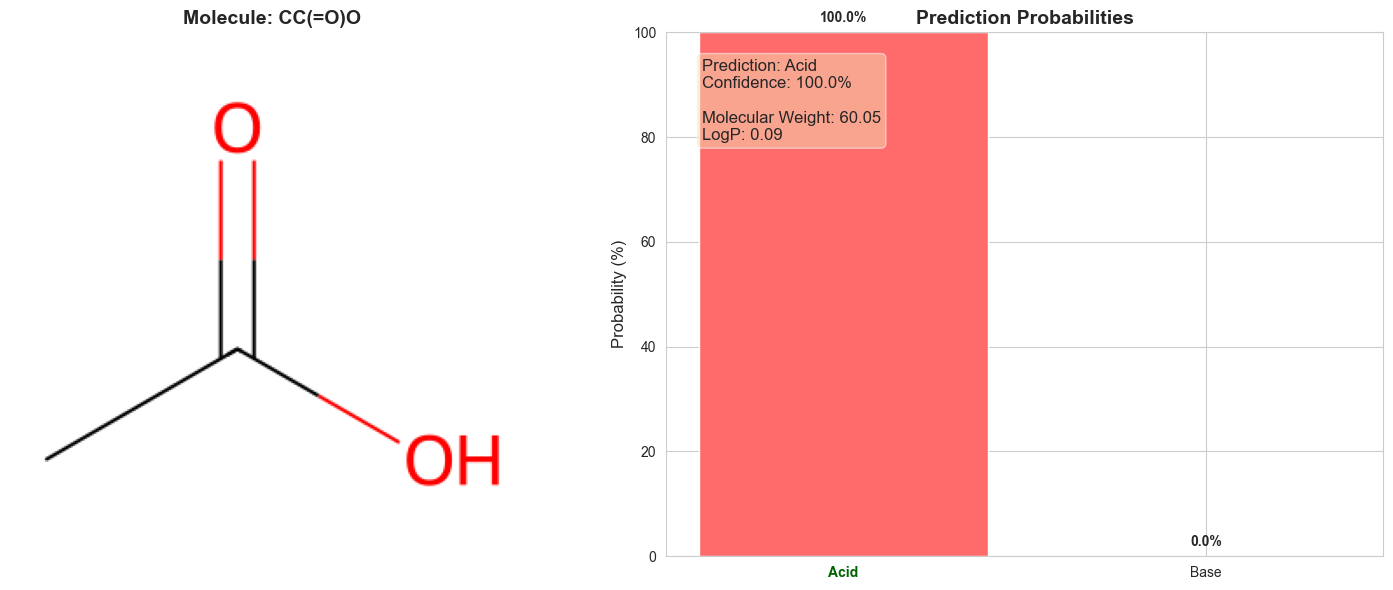


Classification: Acid with 100.0% confidence

Predicting... please wait


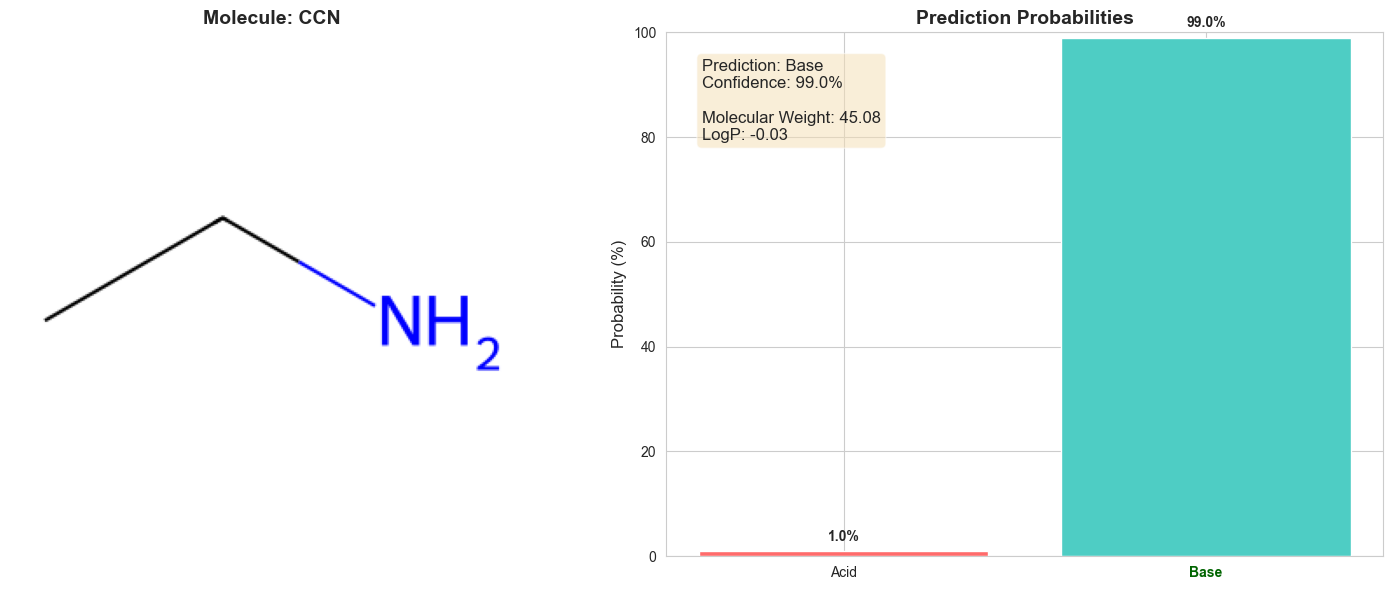


Classification: Base with 99.0% confidence


Thank you for using the acid-base classifier!


In [93]:
print("Enter a SMILES string to get a prediction.")
print("\nExample inputs:")
print("  - CC(=O)O (acetic acid)")
print("  - CCN (ethylamine)")
print("  - c1ccccc1N (aniline)")
print("  - CC(O)C(=O)O (lactic acid)")

while True:
    print("\n" + "=" * 70)
    user_input = input("\nEnter SMILES string (or 'quit' to exit): ").strip()

    if user_input.lower() in ['quit', 'exit', 'q']:
        print("\nThank you for using the acid-base classifier!")
        break

    if not user_input:
        print("Please enter a valid SMILES string.")
        continue

    print("Predicting... please wait")
    time.sleep(0.5)
    result = predict_molecule(user_input, scaler)
    display_prediction(result)

## **Summary and Conclusions**

In this notebook, we've built a machine learning model to classify chemical compounds as acids or bases based on their molecular structure. Here's what we've learned:

1. **Molecular Features**: Certain molecular properties like hydrogen donors, TPSA, and LogP are strong indicators of whether a compound is an acid or a base. These properties align with our chemical understanding of acid-base behavior.

2. **Model Performance**: Our Random Forest classifier achieved high accuracy in distinguishing between acids and bases, demonstrating the effectiveness of machine learning for chemical classification tasks.

3. **Feature Importance**: The most important features for classification were identified, providing insights into the molecular properties that determine acid-base behavior.

4. **Visualization**: We've seen how visualization tools can help us understand both the data and the model's predictions, making the results more interpretable.

### **Potential Applications**

- **Drug Discovery**: Predicting acid-base properties of potential drug candidates
- **Chemical Education**: Teaching students about molecular properties that determine acid-base behavior
- **Chemical Synthesis**: Selecting appropriate reagents based on their acid-base properties

### **Future Improvements**

- Expand the dataset with more diverse chemical structures
- Incorporate quantum chemical descriptors for more accurate predictions
- Develop a multi-class model to predict pKa values rather than binary classification
- Create a web application for easy access to the prediction tool